In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.chdir("C:/Users/Ashlesh B Shetty/Google Drive/LaptopOnDrive/USA_WorkLife/GitHubRepositories/DataScienceProjects/ABTesting_Frequentist_Bayesian_LiveJupyterDashboard")

# ** A/B Testing DEMOCRATIZED **

## A. AB Testing Plotting And Calculation Functions

In [2]:
import scipy.stats as scs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Running AB test
def run_AB_test(N_A, N_B, p_A, p_B, days=10):
    df = pd.concat([
    pd.DataFrame.from_dict({'converted' : scs.bernoulli.rvs(p = p_A, size = N_A),'group' : 'A'}).append(
    pd.DataFrame.from_dict({'converted' : scs.bernoulli.rvs(p = p_B, size = N_B),'group' : 'B'})).sample(frac=1).reset_index(drop=True),
    pd.DataFrame.from_dict({'ts' : pd.qcut(range(N_A + N_B), days, labels = False)})],axis = 1, ignore_index= True)
    df.columns = ['converted','group','ts']

    df_summary = df.groupby(['group']).agg({'converted':['count','sum']}).reset_index()
    df_summary.columns = [' '.join(col).strip() for col in df_summary.columns.values]
    df_summary.columns = ['group','total','converted']
    df_summary['rate'] = df_summary['converted'] /  df_summary['total']

    return df, df_summary

# Expected A B Split plot
def expected_AB_BinomDistributions(N_A, N_B, p_A, p_B, iterations = 10000):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.set(font_scale = 1.2)
    plt.title('Expected Binomial Distribution for A and B split')
    data_binomA = scs.binom.rvs(n=N_A ,p= p_A ,size=iterations)
    sns.kdeplot(data_binomA, shade=True, label = 'A', color = 'gold');
    data_binomB = scs.binom.rvs(n=N_B ,p= p_B ,size=iterations)
    sns.kdeplot(data_binomB, shade=True, label = 'B', color = 'silver');
    plt.xlabel('converted from the base of ' + str(N_A))
    plt.ylabel('probability')
    plt.show()
    
def expected_AB_SampleNormalDistributions(SE_A, SE_B, p_A, p_B, iterations = 10000):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.set(font_scale = 1.2)
    plt.title('Expected Sample Normal Distribution for A and B split')
    norm_A = scs.norm.rvs(p_A, SE_A, iterations)
    sns.kdeplot(norm_A, shade=True, label = 'A');
    ax.axvline(x=p_A, c='blue', alpha=0.5, linestyle='--', label = 'sample mean=' + str(p_A))
    norm_B = scs.norm.rvs(p_B, SE_B, iterations)
    sns.kdeplot(norm_B, shade=True, label = 'B');
    ax.axvline(x=p_B, c='green', alpha=0.5, linestyle='--',label = 'sample mean=' + str(p_B))
    plt.legend()
    plt.xlabel('convertion sample means')
    plt.ylabel('pdf')
    plt.show()

def NullAlternateHypothesis_DifferenceInMeanNormalDistributions(SE_AB, p_A, p_B,z_alpha_by_2, iterations = 10000):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.set(font_scale = 1.2)
    plt.title('A/B Experiment Designing: Power Calculation')
    norm_AltHyp = scs.norm(0 + (p_A - p_B), SE_AB)
    sns.kdeplot(norm_AltHyp.rvs(iterations), shade=False, label = 'Alternate Hyp');
    ax.axvline(x=0 + (p_A - p_B), c='blue', alpha=0.3, linestyle='dotted', label = 'AltHyp mu=' +  '{0:.3f}'.format(0 + (p_A - p_B)) )
    norm_NullHyp = scs.norm(0, SE_AB)
    sns.kdeplot(norm_NullHyp.rvs(iterations), shade=False, label = 'Null Hyp');
    ax.axvline(x=0, c='green', alpha=0.3, linestyle='dotted', label = 'NullHyp mu=0' )
    plt.xlabel('difference in effect means between A and B ')
    plt.ylabel('pdf')
    ax.axvline(x=0 + (z_alpha_by_2 * SE_AB), c='red', alpha=0.3, linestyle='solid', label = 'CI lower=' + str( 1 - significance_level/2 ))
    ax.axvline(x=0 - (z_alpha_by_2 * SE_AB), c='red', alpha=0.3, linestyle='solid', label = 'CI upper=' + str( significance_level/2  ))
    plt.legend()
    x = np.linspace(-10 * SE_AB, 10 * SE_AB, 1000)
    ax.fill_between(x, 0, norm_AltHyp.pdf(x), color='darkorange', alpha='0.5',
                        where=(x > 0 + (z_alpha_by_2 * SE_AB)))
    ax.text(3*(0 + (z_alpha_by_2 * SE_AB)), norm_NullHyp.pdf(0) * 0.8,'power = {0:.3f}'.format(1 - norm_AltHyp.cdf(0 + (z_alpha_by_2 * SE_AB))), fontsize=20, ha='right', color='darkorange')
    plt.show()
    
def hypothesis_testing(ab_summary,z_alpha_by_2, iterations = 10000):
    test_p_B = ab_summary[ab_summary['group'] == 'B']['rate'].values[0]
    test_p_A = ab_summary[ab_summary['group'] == 'A']['rate'].values[0]
    test_N_B = ab_summary[ab_summary['group'] == 'B']['total'].values[0]
    test_N_A = ab_summary[ab_summary['group'] == 'A']['total'].values[0]

    test_SE_AB = np.sqrt((test_p_A*(1-test_p_A)/test_N_A) + (test_p_B*(1-test_p_B)/test_N_B))
    z_score = (test_p_A - test_p_B)/test_SE_AB

    fig, ax = plt.subplots(figsize=(15,5))
    sns.set(font_scale = 1.2)
    plt.title('A/B Testing Result Analysis')
    norm_NullHyp = scs.norm(0, test_SE_AB)
    sns.kdeplot(norm_NullHyp.rvs(iterations), shade=False, label = 'Null Hyp');
    ax.axvline(x=0, c='darkblue', alpha=0.3, linestyle='--', label = 'NullHyp mu=0' )
    plt.xlabel('difference in effect means between A and B ')
    plt.ylabel('pdf')
    ax.axvline(x=0 + (z_alpha_by_2 * test_SE_AB), c='red', alpha=0.3, linestyle='solid', label = 'CI lower=' + str( 1 - significance_level/2 ))
    ax.axvline(x=0 - (z_alpha_by_2 * test_SE_AB), c='red', alpha=0.3, linestyle='solid', label = 'CI upper=' + str( significance_level/2  ))
    ax.axvline(x=0 + (z_score * test_SE_AB), c='darkgreen', alpha=1, linestyle='dashdot', label = 'Z score=' + '{0:.3f}'.format(z_score))    
    plt.legend()

    x = np.linspace(-10 * test_SE_AB, 10 * test_SE_AB, 1000)
    ax.fill_between(x, 0, norm_NullHyp.pdf(x), color='darkgreen', alpha='0.5',
                        where=(x > 0 + (z_score * test_SE_AB)))
    ax.text(-1*(0 + (z_alpha_by_2 * test_SE_AB)), norm_NullHyp.pdf(0) * 0.8,'p-Value = {0:.3f}'.format(1 - norm_NullHyp.cdf(0 + (z_score * test_SE_AB))), 
            fontsize=20, ha='right', color='darkgreen')
    plt.show()

## B. Input Parameters To Design A/B Testing Experiment

In [3]:
#Manual Inputs
p_B = 0.3
sample_size = 1000
effect_size = 0.2
significance_level = 0.05

## C. Internal Calculations

In [4]:
#Internal Calculations
p_A = p_B + (p_B * effect_size)
N_A =int(sample_size/2.0)
N_B = N_A
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(N_A)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(N_B)
SE_AB = np.sqrt((p_A*(1-p_A)/N_A) + (p_B*(1-p_B)/N_B))
z_alpha_by_2 = 0 + scs.norm().ppf(1 - (significance_level/2))

## D. Expected A/B Testing result based on Hypothesis

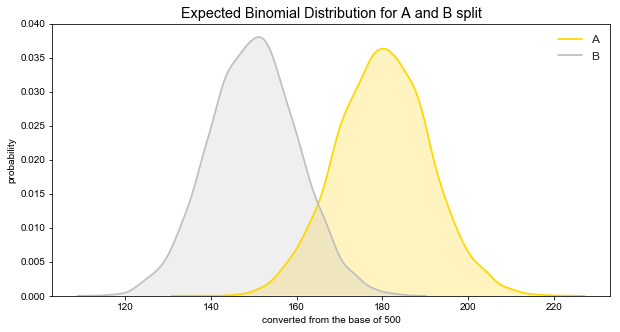

In [5]:
expected_AB_BinomDistributions(N_A, N_B, p_A, p_B)

## E. Desiging A/B Testing Experiment : Sample Size, Effect Size, Power Calculations

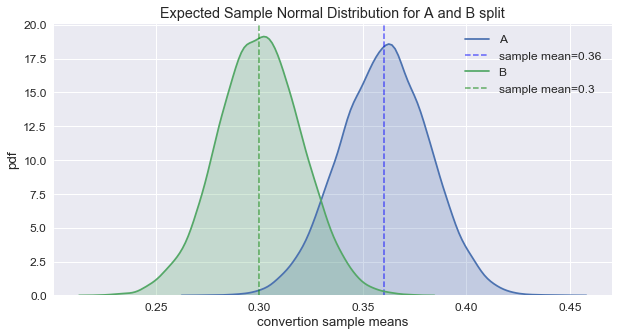

In [6]:
expected_AB_SampleNormalDistributions(SE_A, SE_B, p_A, p_B)

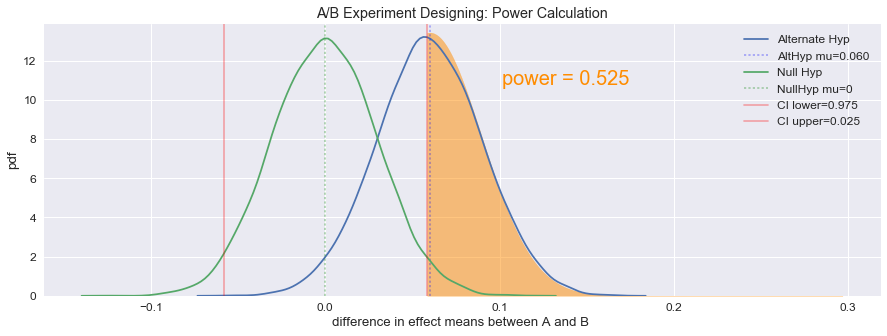

In [7]:
NullAlternateHypothesis_DifferenceInMeanNormalDistributions(SE_AB, p_A, p_B,z_alpha_by_2)

## F. Run A/B Test

In [8]:
# Run A/B Test
ab_data, ab_summary = run_AB_test(N_A, N_B, 0.31, 0.3)
ab_data.sample(5)

,converted,group,ts
227,0,A,2
334,0,B,3
902,0,A,9
90,0,A,0
768,1,B,7


In [9]:
ab_summary

,group,total,converted,rate
0,A,500,167,0.334
1,B,500,151,0.302


## G. Analyze A/B Test Result

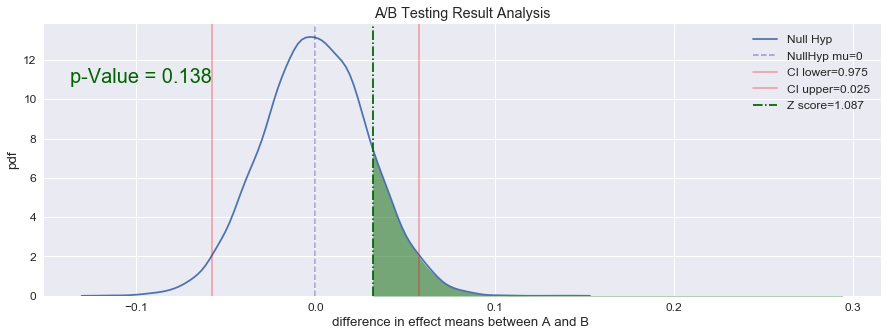

In [10]:
hypothesis_testing(ab_summary,z_alpha_by_2)